# Vector AutoRegression baseline

In [2]:
from utils import *

## Load the data

In [4]:
raw_data = pd.read_csv("fred_md.csv").iloc[1:, :]

raw_data["sasdate"] = pd.to_datetime(raw_data["sasdate"], format="%m/%d/%Y")
raw_data.index = raw_data["sasdate"]

raw_data.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,PERMIT,PERMITNE,PERMITMW,PERMITS,PERMITW,ACOGNO,AMDMNOx,ANDENOx,AMDMUOx,BUSINVx,ISRATIOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,NONREVSL,CONSPI,S&P 500,S&P: indust,S&P div yield,S&P PE ratio,FEDFUNDS,CP3Mx,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,COMPAPFFx,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1959-01-01,1959-01-01,2442.158,2293.200,17.272,292266.426,18235.774,22.015,23.398,22.285,31.585,18.686,38.150,8.148,20.131,12.139,30.652,20.896,19.918,34.670,80.197,1357.000,0.334,67936.000,63868.000,6.000,16.300,1574.000,1169.000,1396.000,594.000,802.000,291078.000,52478.000,18796.000,713.000,2993.000,14998.000,8740.000,6258.000,33682.000,10774.000,2568.700,5350.300,2418.000,8105.000,39.800,2.500,40.200,1657.000,350.000,452.000,505.000,350.000,NaN,NaN,NaN,NaN,NaN,NaN,14716.483,NaN,42620.346,84889.559,1.560,138.900,286.600,987.900,50500.000,18.900,18300.000,35.213,24.924,48.961,0.125,55.620,59.300,3.158,18.446,2.480,3.300,2.820,3.090,3.360,4.010,4.020,4.120,4.870,0.820,0.340,0.610,0.880,1.530,1.540,1.640,2.390,NaN,4.312,359.842,2.807,0.967,33.100,33.400,30.600,31.600,3.000,32.500,29.010,44.800,29.300,21.100,33.300,38.100,22.900,28.900,30.700,29.600,16.042,56.918,17.791,11.326,2.130,2.450,2.040,NaN,6476.000,12298.000,84.204,NaN
1959-02-01,1959-02-01,2451.778,2301.500,17.452,294424.742,18369.563,22.446,23.714,22.478,31.816,18.784,38.515,8.257,20.769,12.698,31.189,21.280,19.863,34.198,81.443,1421.000,0.358,67649.000,63684.000,5.900,15.500,1554.000,1164.000,1277.000,545.000,732.000,282958.000,52688.000,18890.000,704.200,2980.000,15115.000,8839.000,6276.000,33798.000,10816.000,2575.400,5381.300,2420.000,8116.000,39.700,2.600,40.300,1667.000,346.000,469.000,508.000,344.000,NaN,NaN,NaN,NaN,NaN,NaN,15400.249,NaN,43677.152,85181.811,1.539,139.400,287.700,992.100,49800.000,18.600,18100.000,35.220,25.227,49.514,0.126,54.770,58.330,3.220,18.418,2.430,3.260,2.700,3.130,3.540,3.960,3.960,4.140,4.890,0.830,0.270,0.700,1.110,1.530,1.530,1.710,2.460,NaN,4.313,359.842,2.809,0.975,33.200,33.400,30.700,31.400,3.000,32.500,29.000,44.700,29.400,21.200,33.300,38.100,23.000,28.900,30.700,29.600,16.057,56.951,17.798,11.343,2.140,2.460,2.050,NaN,6476.000,12298.000,83.528,NaN
1959-03-01,1959-03-01,2467.594,2318.500,17.617,293418.670,18523.058,22.770,23.858,22.588,31.816,19.152,38.333,8.346,21.308,13.198,31.657,21.613,19.999,35.064,82.477,1524.000,0.401,68068.000,64267.000,5.600,15.300,1459.000,1093.000,1210.000,530.000,680.000,260346.000,53014.000,19069.000,704.100,3013.000,15259.000,8965.000,6294.000,33945.000,10873.000,2584.400,5431.600,2430.000,8132.000,40.000,2.800,40.400,1620.000,330.000,413.000,503.000,374.000,NaN,NaN,NaN,NaN,NaN,NaN,15745.423,NaN,44781.647,85620.190,1.529,139.700,289.200,998.300,49700.000,18.400,17800.000,35.130,25.422,50.008,0.126,56.160,59.790,3.152,18.999,2.800,3.350,2.800,3.130,3.610,3.990,3.990,4.130,4.850,0.550,0.000,0.330,0.810,1.190,1.190,1.330,2.050,NaN,4.323,359.842,2.813,0.970,33.200,33.300,30.700,31.500,2.970,32.900,28.970,44.700,29.600,21.300,33.200,38.300,23.000,28.900,30.700,29.600,16.068,57.0

## Data preprocessing

In [5]:
full_data = raw_data[list(features_to_names.keys())].copy()
for f, transf in feat_to_transform.items():
    full_data[f] = transf(full_data[f])
full_data = full_data.rename(columns=features_to_names)

while pd.isnull(full_data["real_income"].iloc[-1]):
    full_data = full_data.iloc[:-1, :]
while pd.isnull(full_data["real_income"].iloc[0]):
    full_data = full_data.iloc[1:, :]
    
data = full_data[full_data.index < "2019-01-01"]

## Simple 1 month VAR prediction

### Tuning the number of lags in the model

In [7]:
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def run_var_cv(df, init_rows_train, p):
    results = dict(zip(df.columns, [[] for _ in range(len(df.columns))]))

    for train_end_ind in tqdm(range(init_rows_train, len(df))):
        train = df.iloc[0:train_end_ind]
        X_train = train.values
        test = df.iloc[train_end_ind]

        model = VAR(X_train).fit(p)
        # Predicting the last train observation by taking p but the last observations
        X_train_pred = model.forecast(X_train[-model.k_ar - 1:-1], steps=1)
        # Predicting next observation based on last train p observations
        X_test_pred = model.forecast(X_train[-model.k_ar:], steps=1)
        for i, f in enumerate(df.columns):
            results[f].append({"last_train_date": train.iloc[-1].name,
                          "last_train": train[f].iloc[-1],
                          "test_date": test.name,
                          "test": test[f],
                          "train_pred": X_train_pred[0][i],
                          "test_pred": X_test_pred[0][i]})

    for f in df.columns:
        results[f] = pd.DataFrame(results[f])
        
    return results

In [8]:
init_rows_train = 12 * 40
ps = list(range(1, 13))
metric = mean_squared_error

p_results = []
for p in tqdm(ps):
    res = run_var_cv(data, init_rows_train, p)
    for f in data.columns:
        p_results.append({
            "p" : p,
            "feature": f,
            "var_train_result": metric(res[f]["last_train"], res[f]["train_pred"]),
            "var_test_result": metric(res[f]["test"], res[f]["test_pred"])
        })
p_results = pd.DataFrame(p_results)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

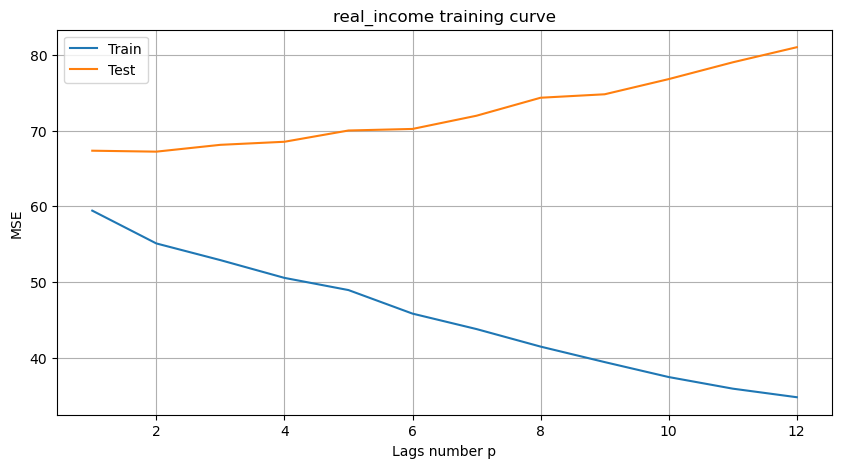

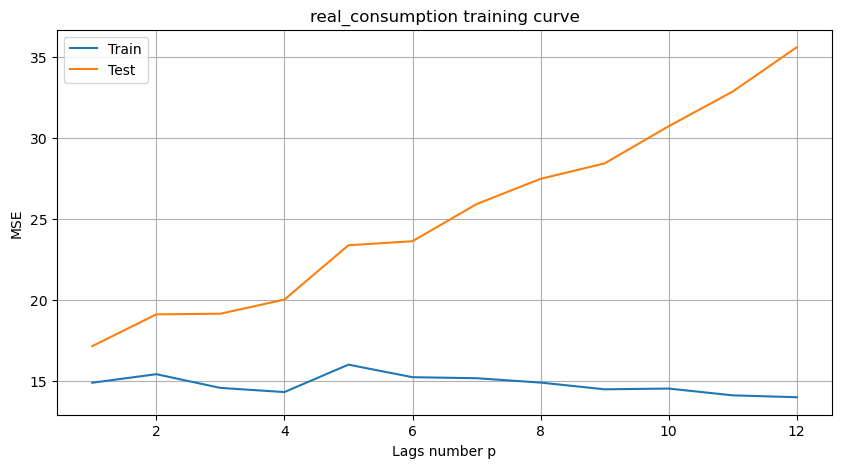

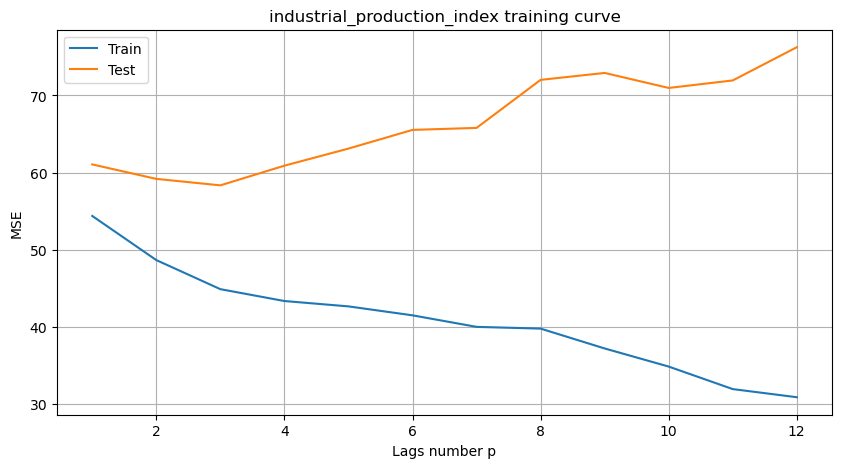

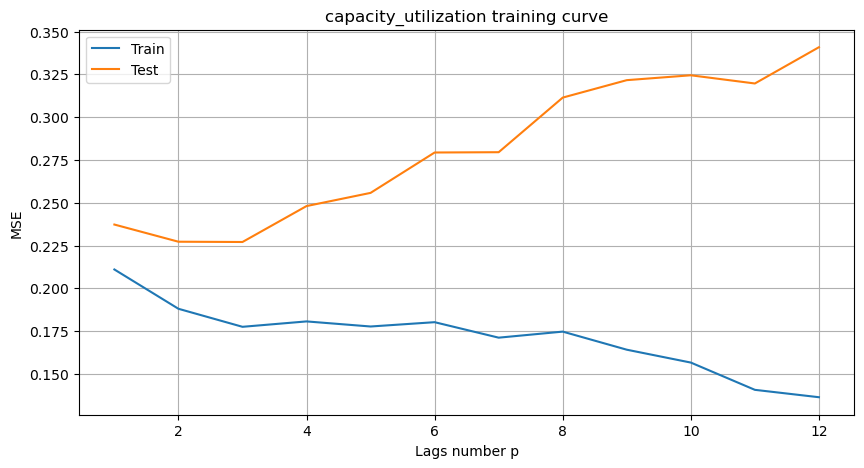

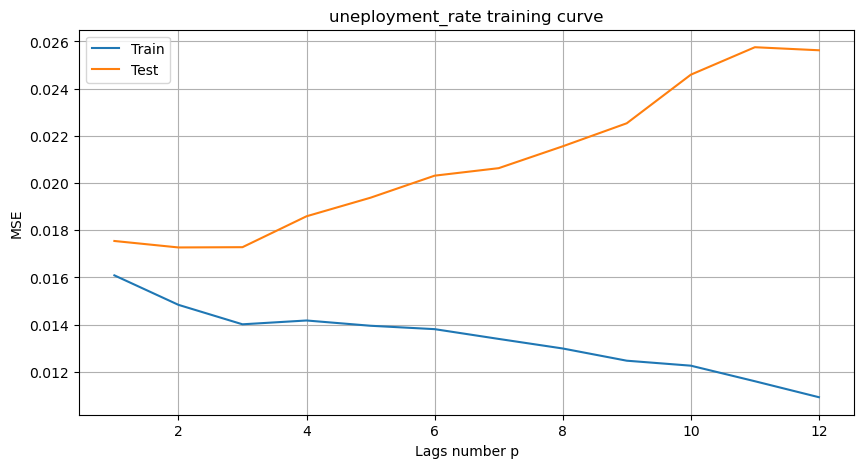

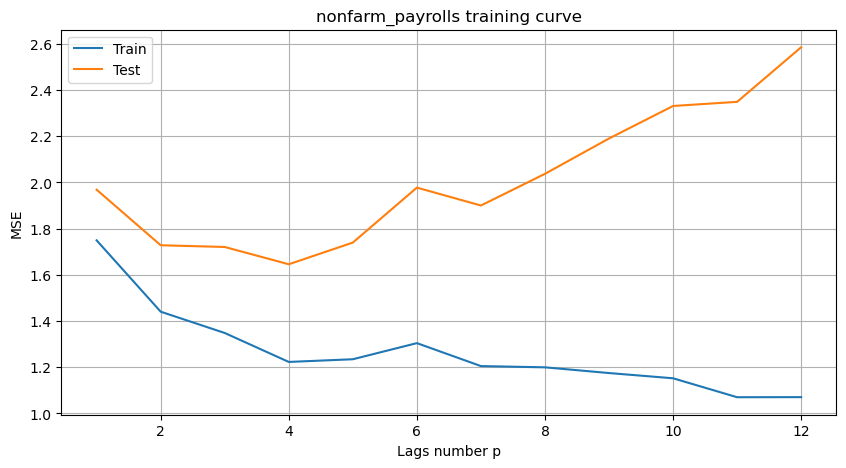

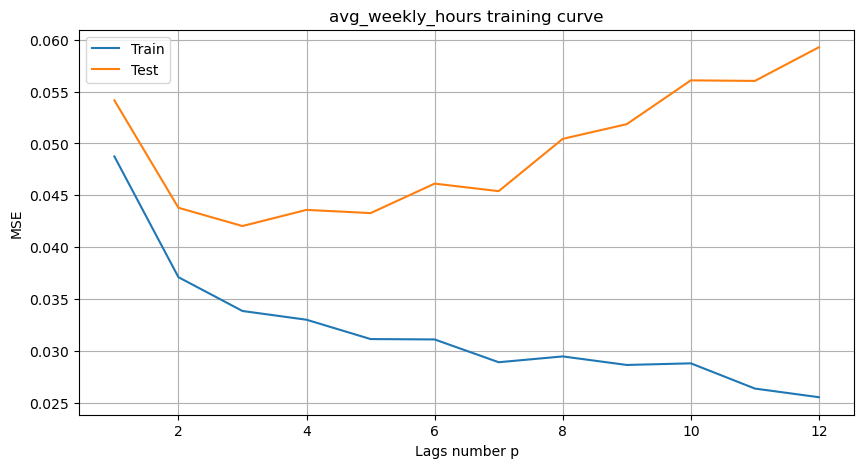

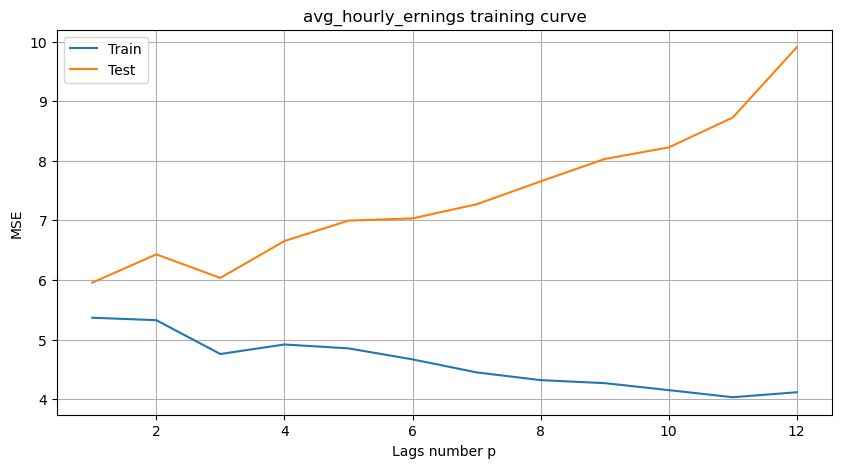

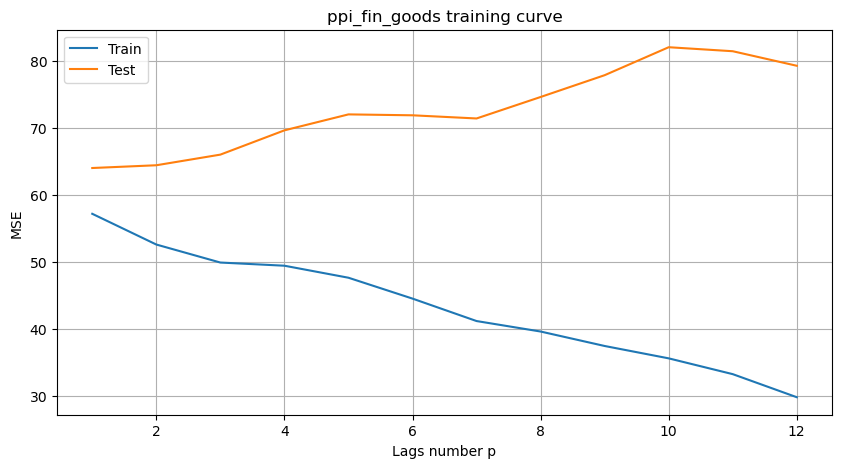

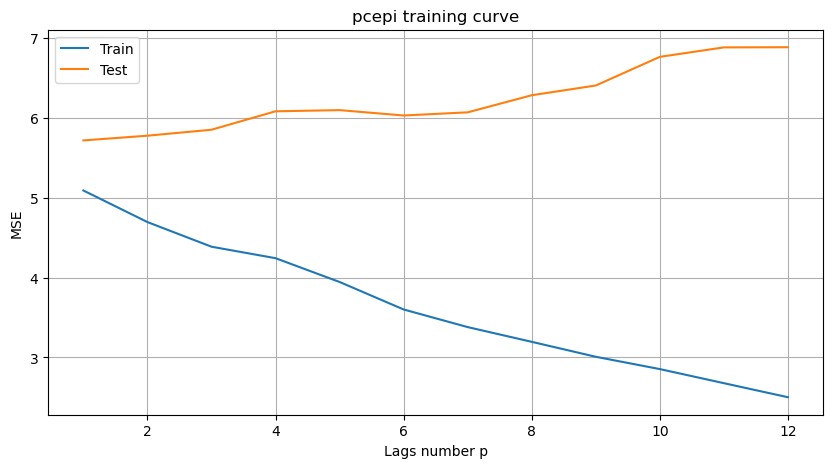

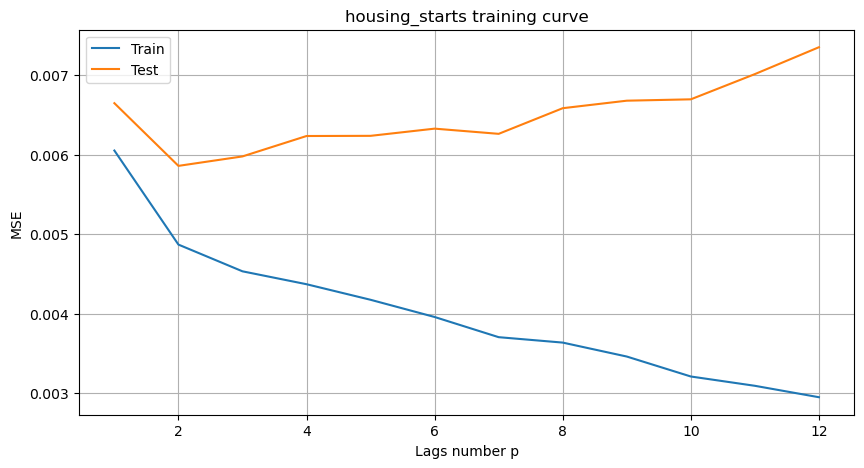

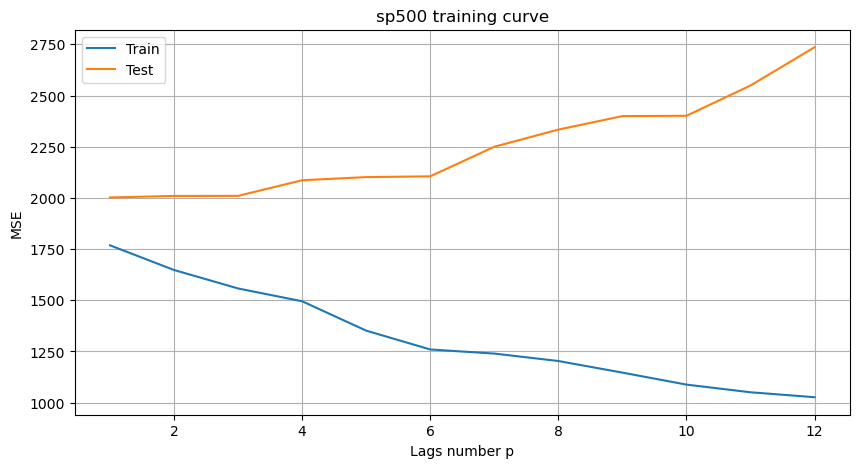

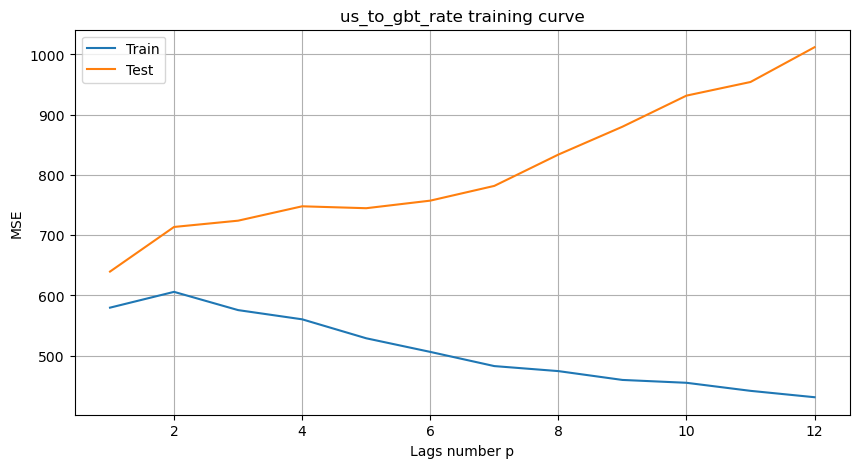

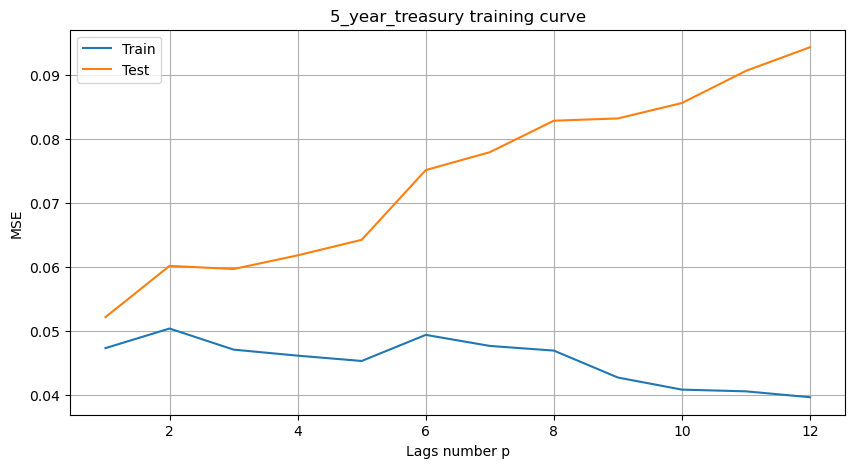

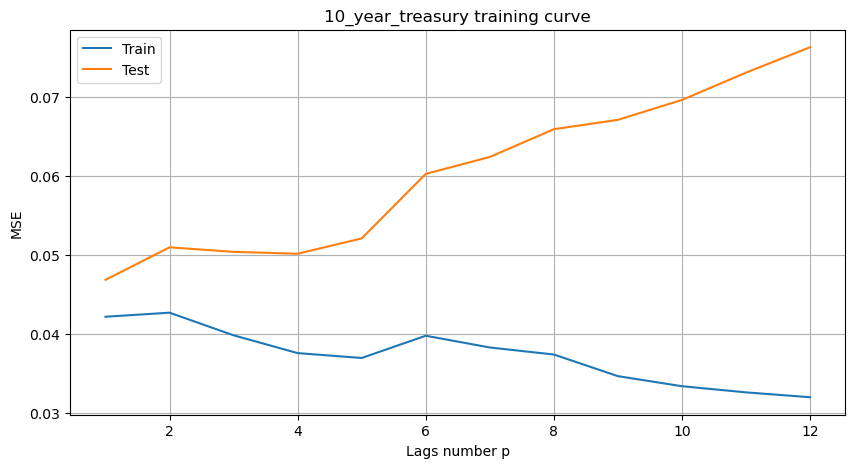

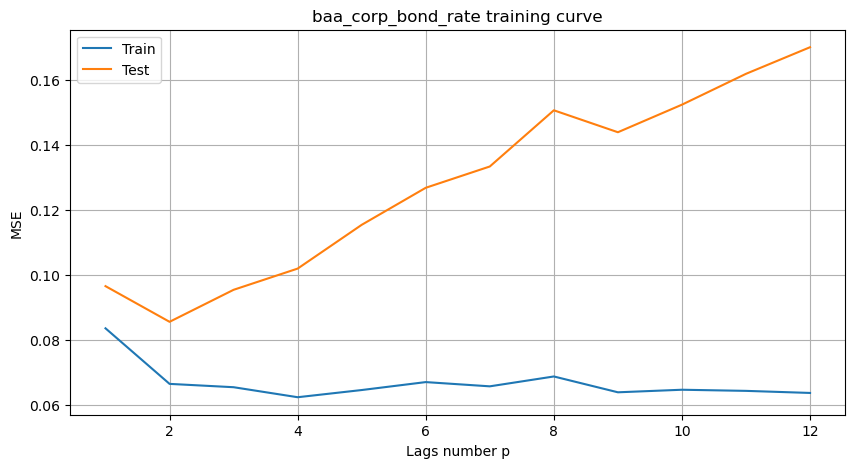

In [9]:
for f in data.columns:
    res = p_results[p_results["feature"] == f].sort_values("p")
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.grid()
    sns.lineplot(x=ps, y=res["var_train_result"], label="Train")
    sns.lineplot(x=ps, y=res["var_test_result"], label="Test")
    plt.xlabel("Lags number p")
    plt.ylabel("MSE")
    plt.title(f"{f} training curve")

### Analyzing the best results

In [10]:
best_p = 1
results = run_var_cv(data, init_rows_train, best_p)

  0%|          | 0/239 [00:00<?, ?it/s]

In [11]:
metrics = {
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error
}

metric_df = []
for f in data.columns:
    for m in metrics:
        metric_df.append({"feature": f, 
                          "metric": m,
                          "var_train_result": metrics[m](results[f]["last_train"], results[f]["train_pred"]),
                          "var_test_result": metrics[m](results[f]["test"], results[f]["test_pred"]), 
                          "const_test_result": metrics[m](results[f]["test"], results[f]["last_train"])})
metric_df = pd.DataFrame(metric_df)

In [12]:
metric_df[metric_df["metric"] == "mse"]

,feature,metric,var_train_result,var_test_result,const_test_result
0,real_income,mse,59.426,67.350,145.377
3,real_consumption,mse,14.916,17.176,45.732
6,industrial_production_index,mse,54.369,61.054,92.927
9,capacity_utilization,mse,0.211,0.237,0.251
12,uneployment_rate,mse,0.016,0.018,0.025
15,nonfarm_payrolls,mse,1.749,1.969,1.559
18,avg_weekly_hours,mse,0.049,0.054,0.042
21,avg_hourly_ernings,mse,5.366,5.955,8.276
24,ppi_fin_goods,mse,57.188,64.008,103.834
27,pcepi,mse,5.093,5.721,7.127


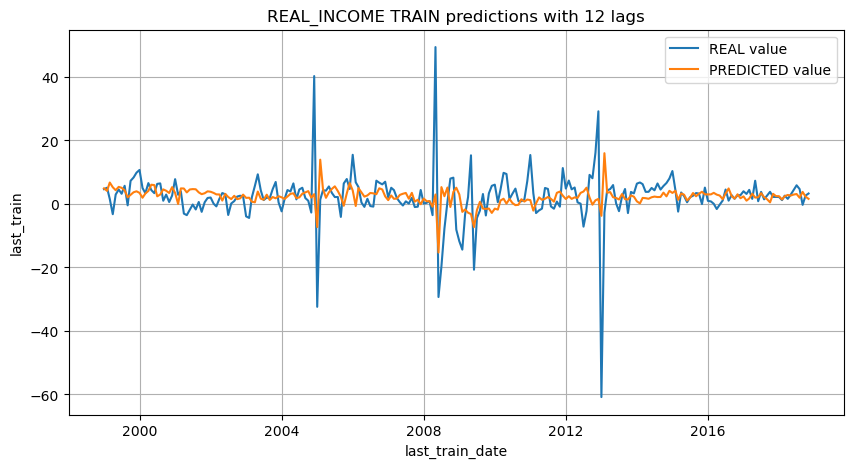

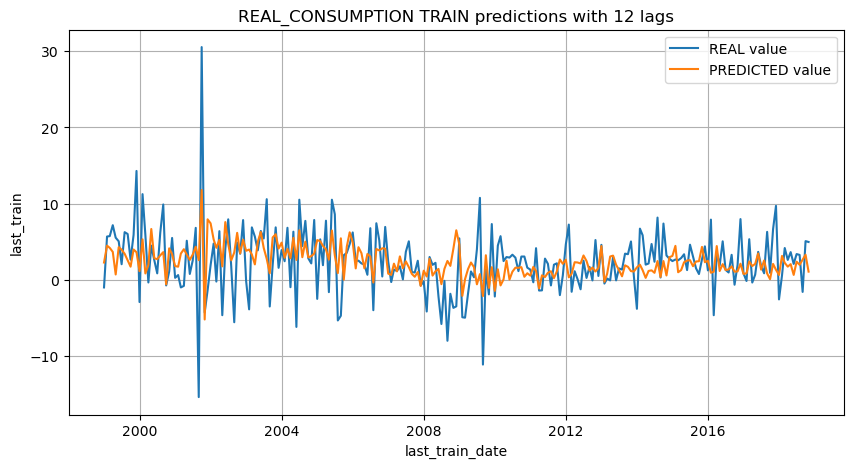

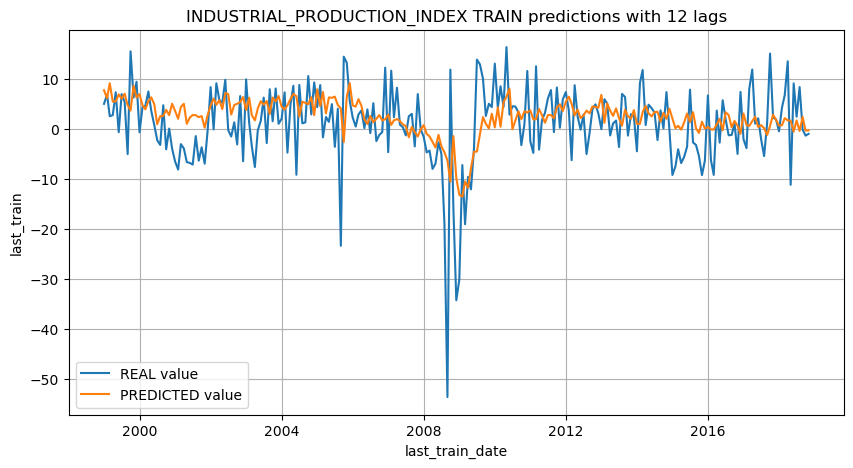

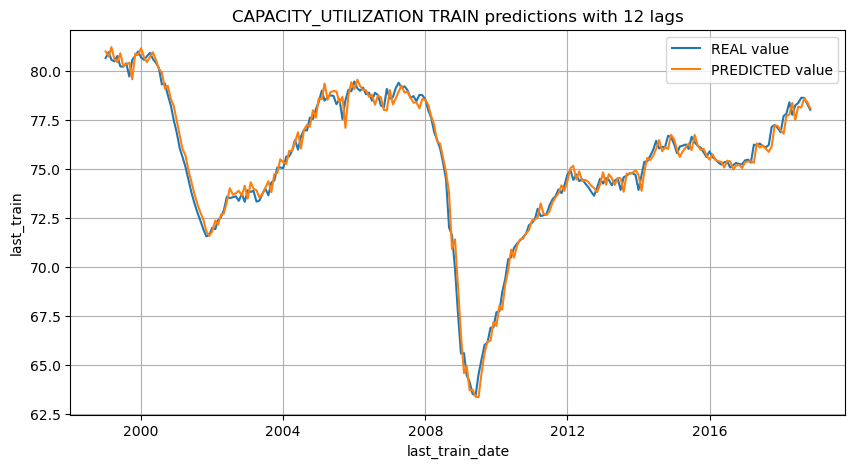

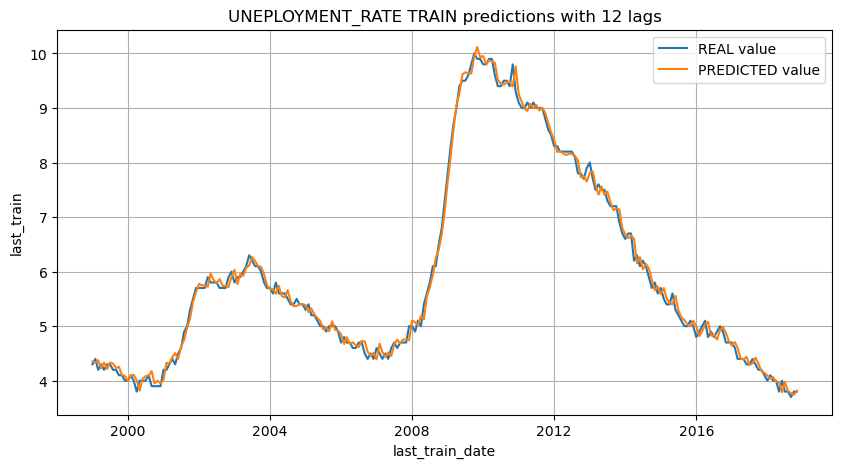

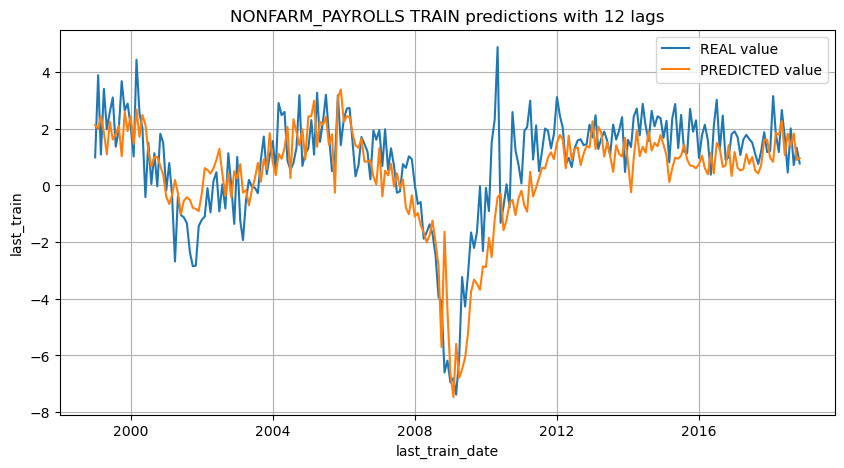

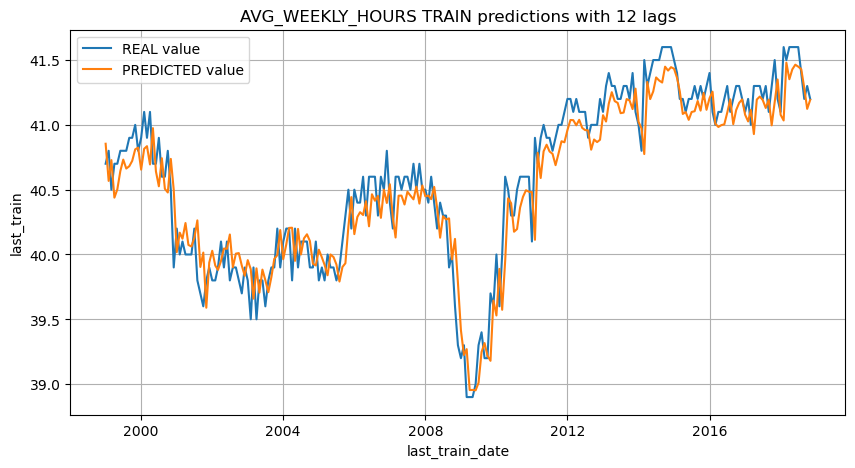

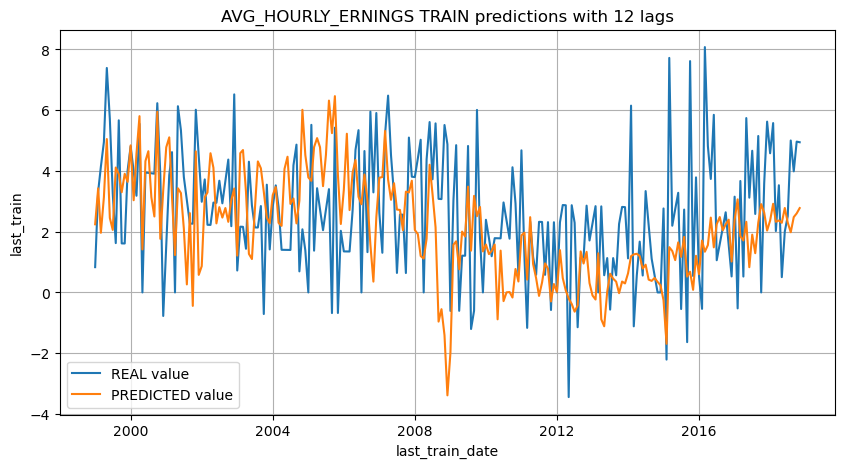

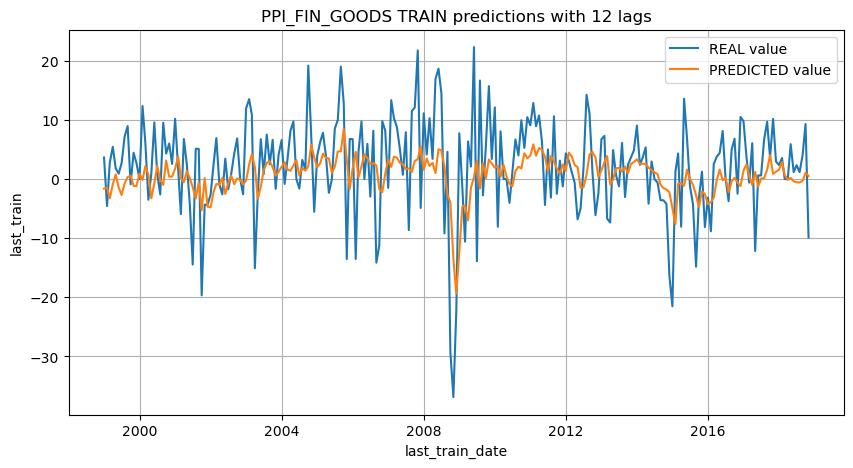

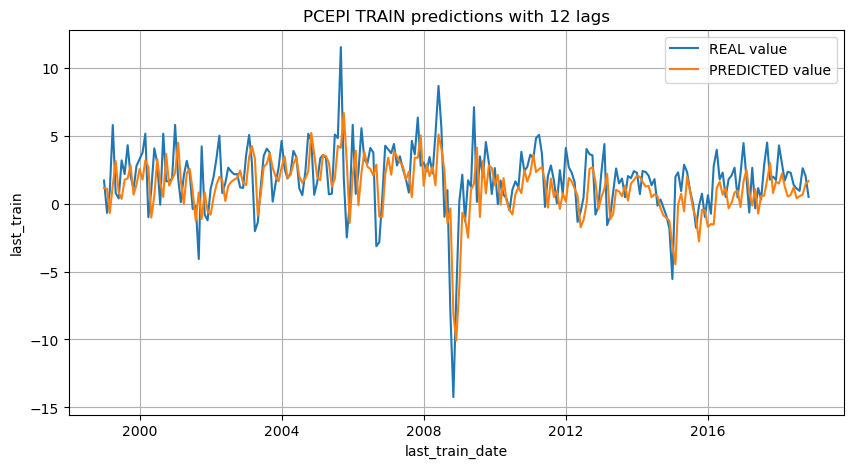

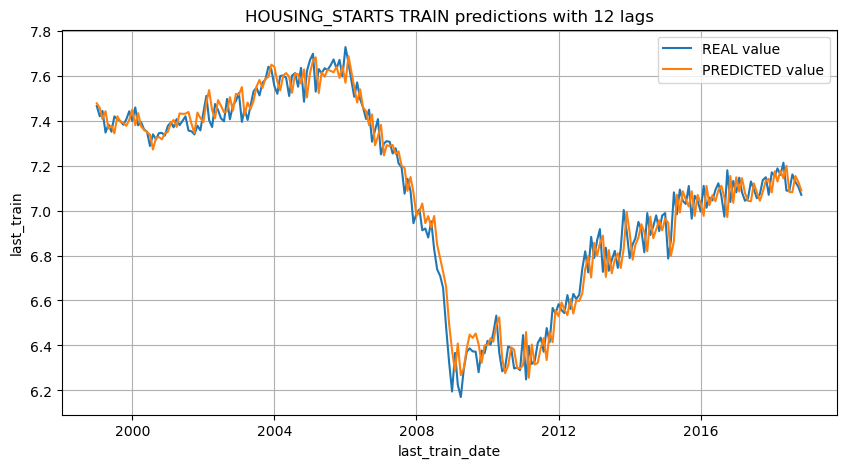

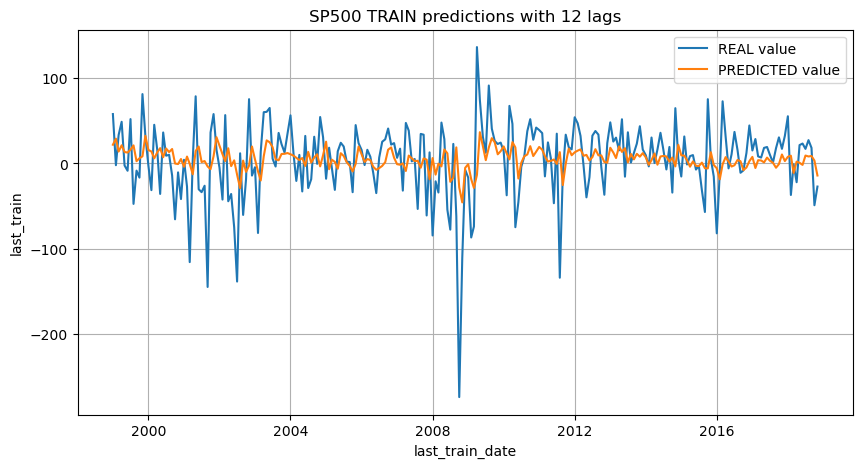

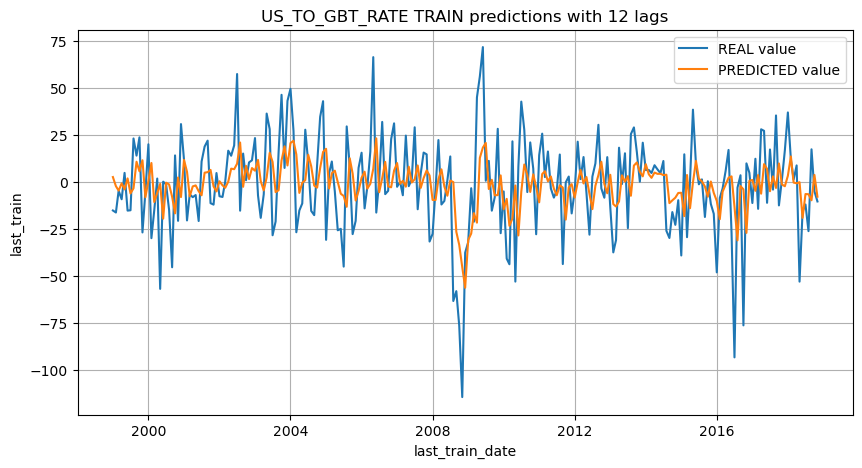

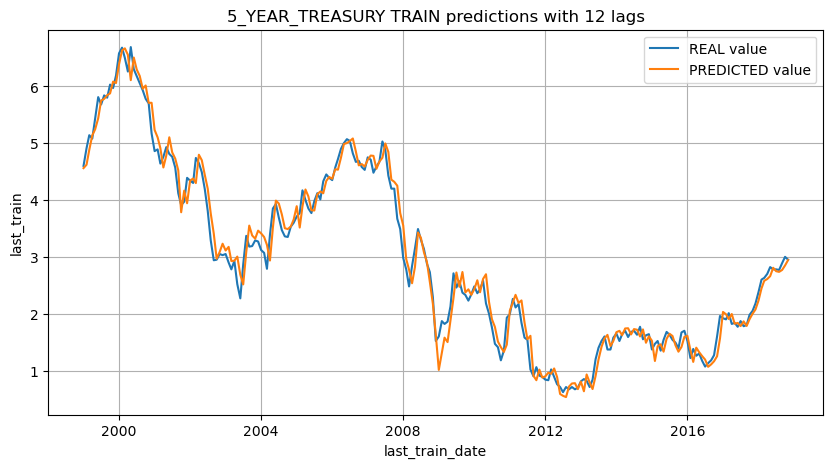

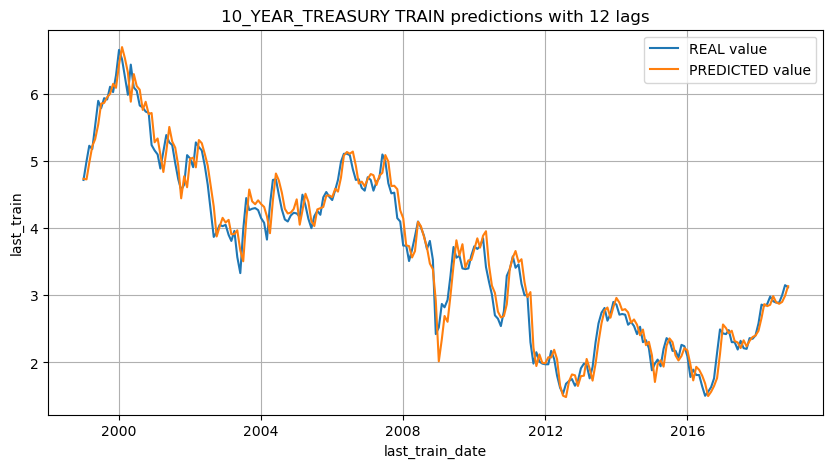

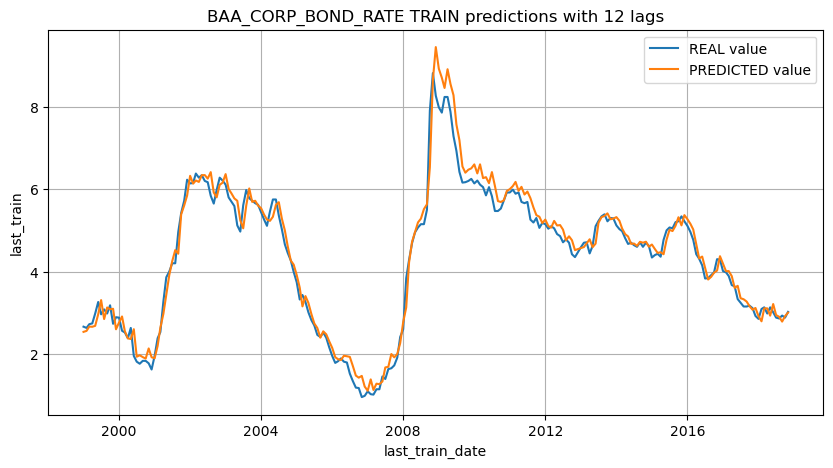

In [14]:
for f in data.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.grid()
    sns.lineplot(x=results[f]["last_train_date"], y=results[f]["last_train"], label="REAL value");
    sns.lineplot(x=results[f]["last_train_date"], y=results[f]["train_pred"], label="PREDICTED value");
    plt.title(f"{f.upper()} TRAIN predictions with {p} lags");

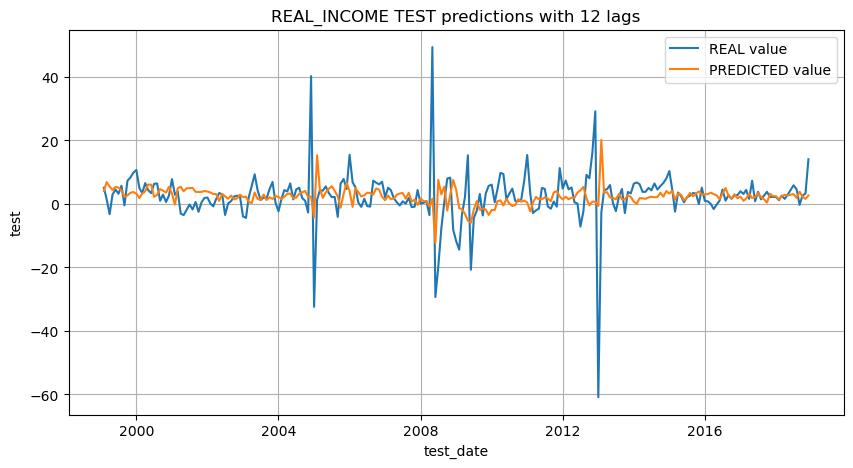

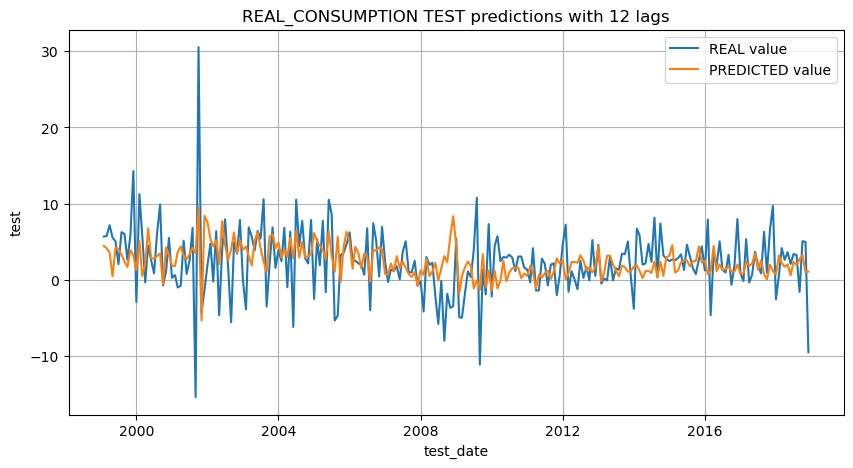

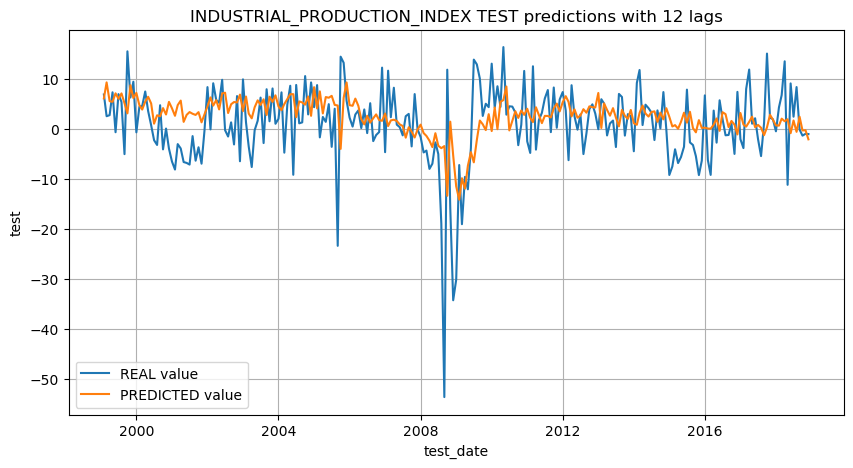

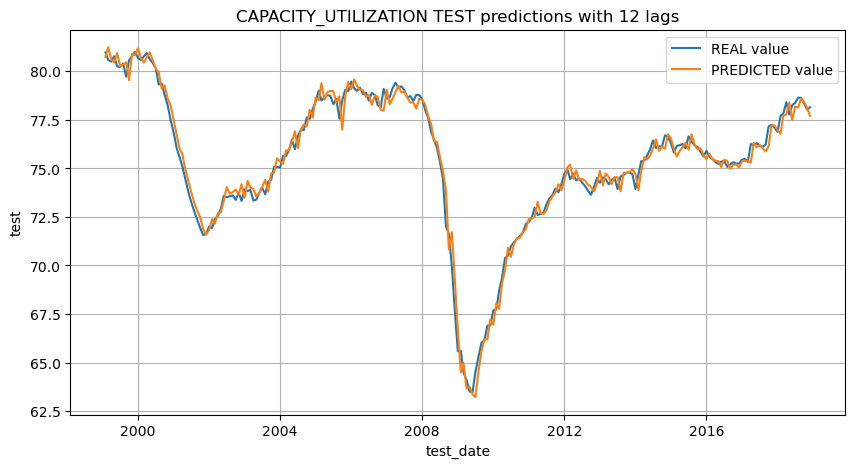

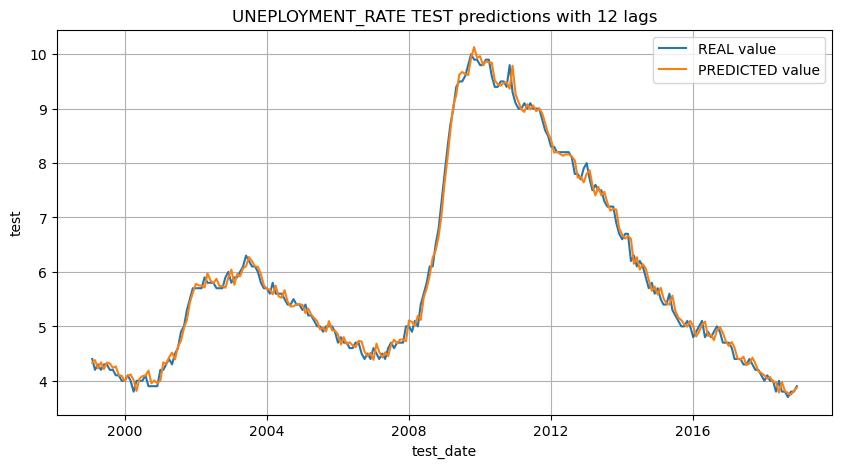

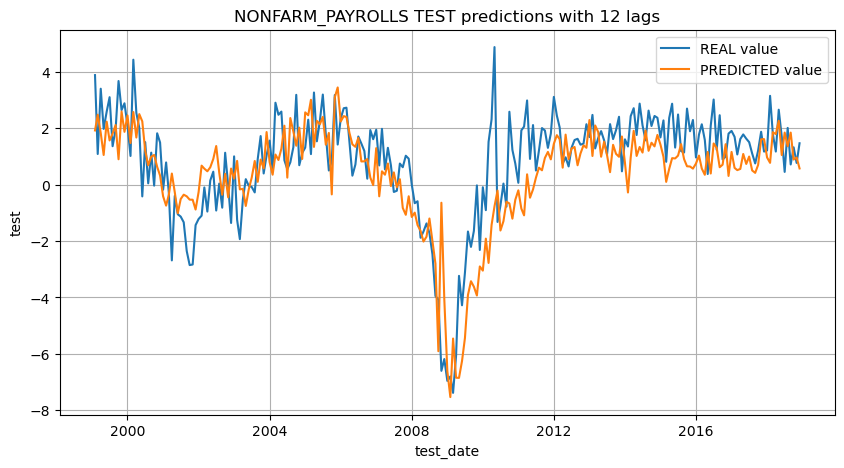

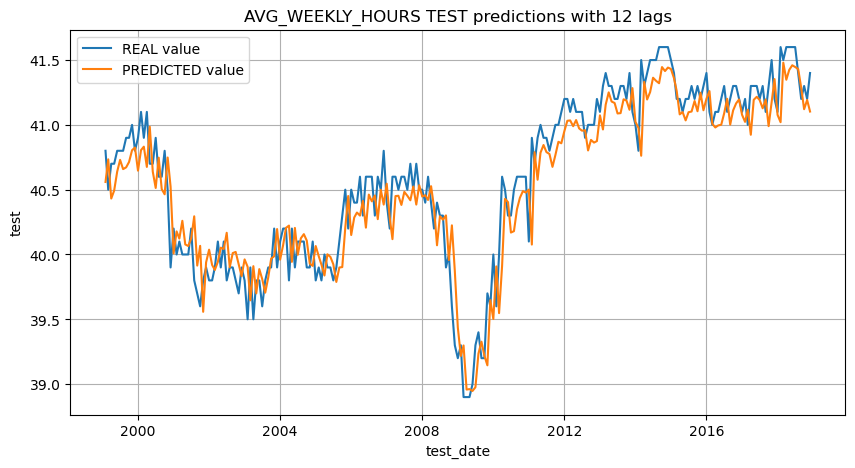

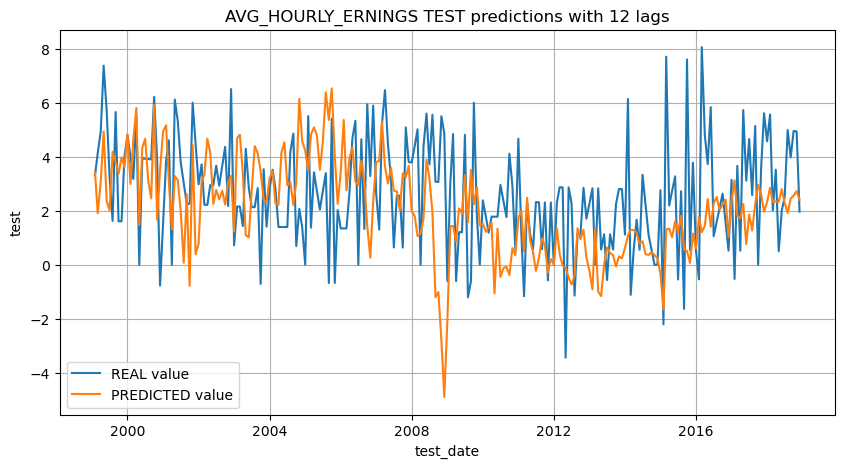

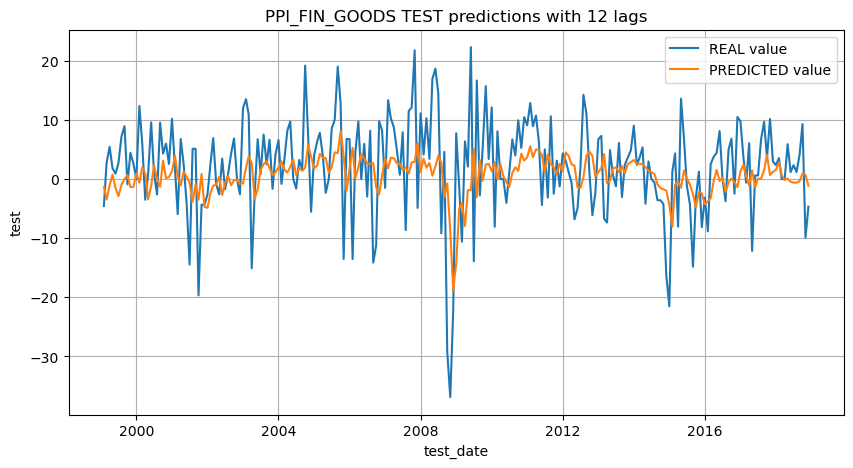

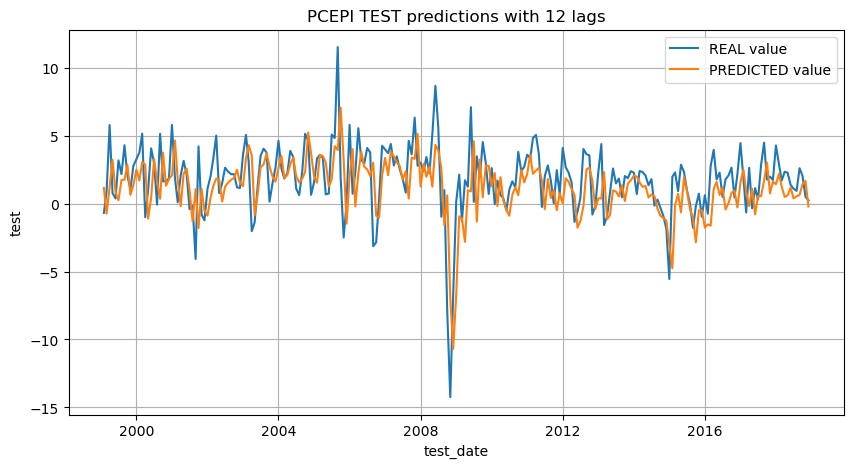

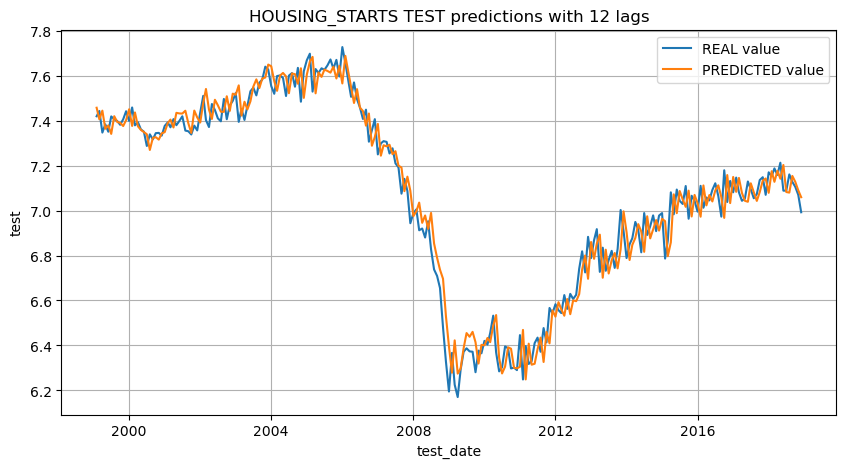

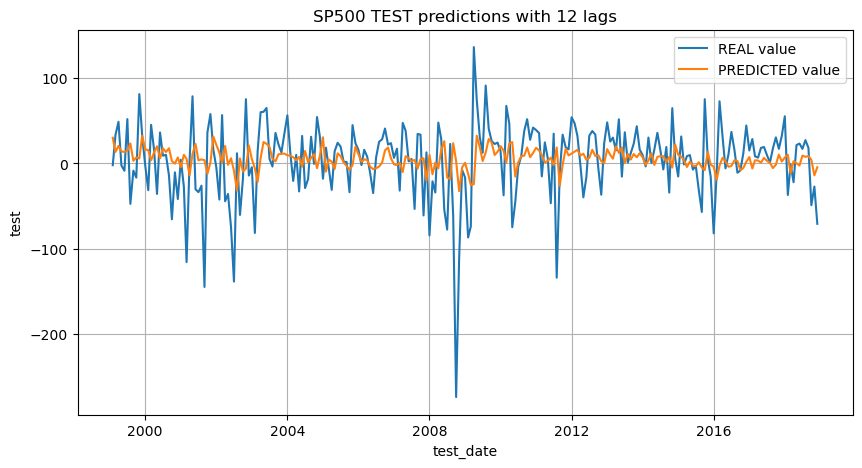

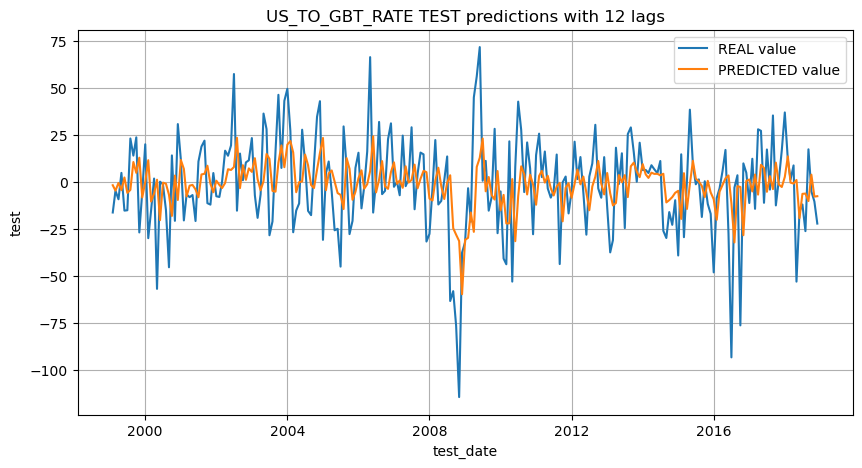

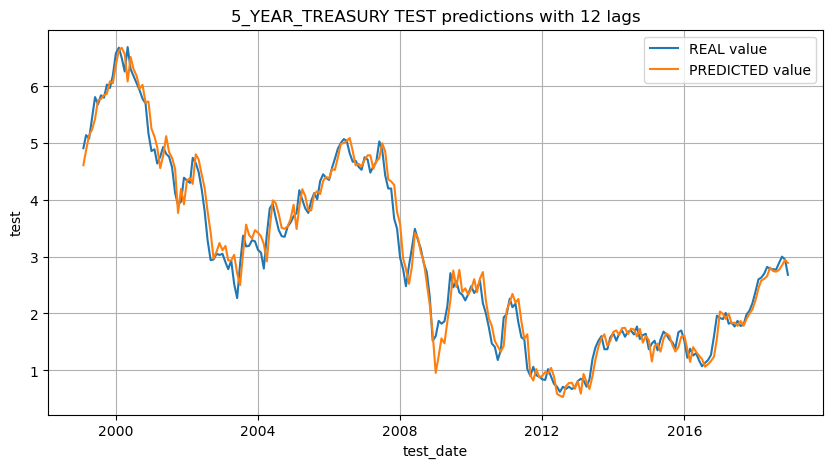

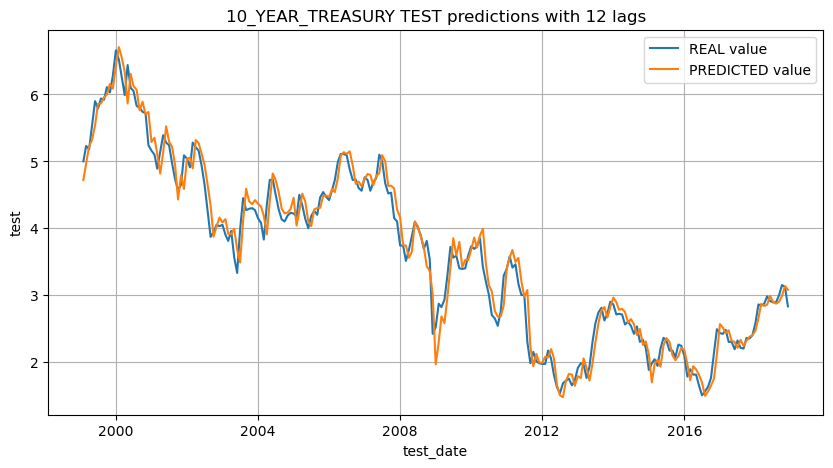

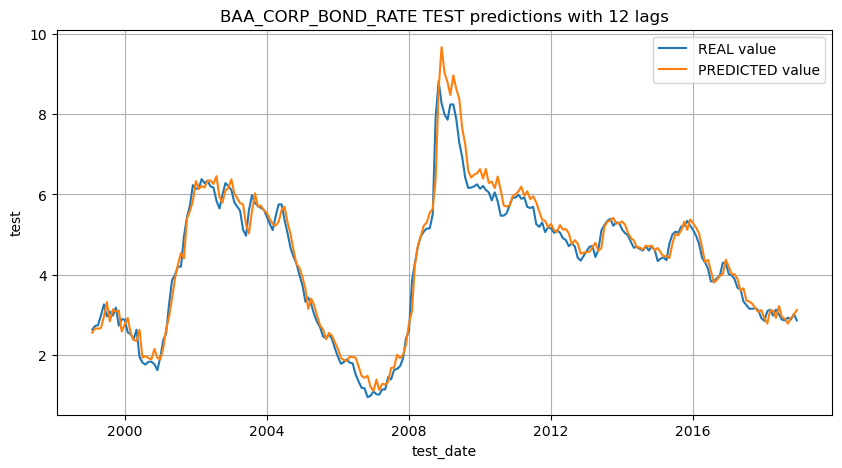

In [15]:
for f in data.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.grid()
    sns.lineplot(x=results[f]["test_date"], y=results[f]["test"], label="REAL value");
    sns.lineplot(x=results[f]["test_date"], y=results[f]["test_pred"], label="PREDICTED value");
    plt.title(f"{f.upper()} TEST predictions with {p} lags");

It seems like that thing is not about overfitting. We need to think more about the reasons of poor VAR performance

**Interesting observations**
- The higher is amount of lags the better is train error and the worse is the test one
- The proposition above is true starting from number of lags = 1. And that is quite reasonable, since model with many macroeconomic variables tend to overfit just by a design. For lag=1 VAR already has 16^2 * 1 + 16 = 272 parameters, for lag=2 it is 16^2 * 2 + 16 = 528. We simply will not have enought data to train those parameters.
- There are some *easy-to-predict* variables for which the VAR model predictions are close to constant lag-1 ones. These are *capacity utilization, uneployment rate, average weekly hours, housing starts, 5 year treasury, 10 year treasury.* Their removal from the model does not change the picture drastically, just improves results for individual positions.

**TO DO**
- Check if removing outliers can improve the result
- Apply some sort of regularization for VAR